# Early detection of 3D printing issues
by\
*Eliott Nys (195193)* \
*Joseph Mimassi (195178)*

## Imports
### Libraries

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import *
import tensorflow as tf
from tensorflow.keras import backend as K
# from keras.metrics import Precision, Recall
# from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model

### Data

In [54]:
train = pd.read_csv("/kaggle/input/early-detection-of-3d-printing-issues/train.csv")
test = pd.read_csv("/kaggle/input/early-detection-of-3d-printing-issues/test.csv")

## Explore Data

Let's start by taking a look at the data.

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81060 entries, 0 to 81059
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   img_path             81060 non-null  object
 1   printer_id           81060 non-null  int64 
 2   print_id             81060 non-null  int64 
 3   has_under_extrusion  81060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.5+ MB


In [56]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_path    25279 non-null  object
 1   printer_id  25279 non-null  int64 
 2   print_id    25279 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 592.6+ KB


In [57]:
train.head()

,img_path,printer_id,print_id,has_under_extrusion
0,101/1678589738/1678589914.060332.jpg,101,1678589738,1
1,101/1678589738/1678589914.462857.jpg,101,1678589738,1
2,101/1678589738/1678589914.875075.jpg,101,1678589738,1
3,101/1678589738/1678589915.284495.jpg,101,1678589738,1
4,101/1678589738/1678589915.700486.jpg,101,1678589738,1


For each image, we are given the **path** to the image, the **printer** that was used (through an ID) and the **printjob** in which the image was taken (also through an ID) and of course the target (in the training set) : wether or not there is **under-extrusion** (0 or 1). Both the ID's are in integer form. The training set contains 81060 images, the test set contains 25279 images. There are no missing values.

In [58]:
train.printer_id.unique()

array([101, 102, 103, 104,  22])

In [59]:
test.printer_id.unique()

array([101, 102,  23, 103, 104,  21,  22])

Like explained on the competition page, the **printers 21 and 23** have been **withheld** from the train set to check for overfitting (because of the limited number of printers). All the printers in the training set also appear in the test set, because some prints for every printer are witheld for the test set, again to avoid overfitting, but within the same printers.\
It is also worth noting that the dataset is quite **balanced**:

1    44342
0    36718
Name: has_under_extrusion, dtype: int64


([<matplotlib.patches.Wedge at 0x7ea5ce310a00>,
 [Text(-1.0880170279506314, -0.16192265712208206, 'extrusion'),
  Text(1.08801704311092, 0.1619225552545753, 'no extrusion')],
 [Text(-0.593463833427617, -0.08832144933931747, '54.7%'),
  Text(0.5934638416968653, 0.08832139377522288, '45.3%')])

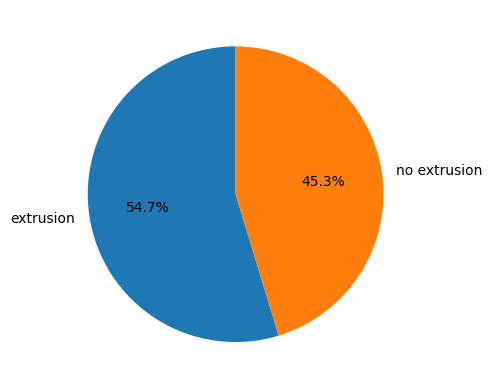

In [60]:
balance = train.has_under_extrusion.value_counts()
print(balance)
plt.pie(balance, labels=["extrusion", "no extrusion"], autopct='%1.1f%%', startangle=90)

Before continuing, we have to correct a problem with the data. When we imported the data, we noticed the img_path feature does not match with the actual image paths from the imported data. We therefore added a feature **"actual_img_path"** containing the corrected image path.

In [61]:
train['has_under_extrusion'] = train['has_under_extrusion'].astype(str)   #y_col in data_generator needs to be of type string
train['actual_img_path'] = train['has_under_extrusion'] + "/" + train['img_path'].apply(lambda x: x.split("/")[2])
train.head()

,img_path,printer_id,print_id,has_under_extrusion,actual_img_path
0,101/1678589738/1678589914.060332.jpg,101,1678589738,1,1/1678589914.060332.jpg
1,101/1678589738/1678589914.462857.jpg,101,1678589738,1,1/1678589914.462857.jpg
2,101/1678589738/1678589914.875075.jpg,101,1678589738,1,1/1678589914.875075.jpg
3,101/1678589738/1678589915.284495.jpg,101,1678589738,1,1/1678589915.284495.jpg
4,101/1678589738/1678589915.700486.jpg,101,1678589738,1,1/1678589915.700486.jpg


## First Pipeline
Our code is based on the kaggle courses about Deep Learning and Computer Vision, which is why we used the keras library.
### Split data
Let's start by splitting the train.csv data into a training set and a validation set.
In the same spirit as the split into train.csv and test.csv, we first tried to withold a printer from the training set. We first check the number of lines and prints per printer, to make sure we do not reserve a printer with less data or prints than the other printers.

Number of images per printer:

In [62]:
train[['printer_id', 'has_under_extrusion']].groupby(['printer_id']).count()

,has_under_extrusion
printer_id,
22,7492
101,20205
102,22670
103,9927
104,20766


Number of prints per printer:

In [63]:
train[['printer_id', 'print_id', 'has_under_extrusion']].groupby(['printer_id', 'print_id']).count().groupby(['printer_id']).count()

,has_under_extrusion
printer_id,
22,17
101,9
102,6
103,8
104,12


We chose to retain the printer 103 along with 10% of the remaining images for the training set. That brings us to about 20% of validation data, half of which is from a 'new' printer.

In [64]:
val_reserved_printer = train[train['printer_id'] == 103]
train_data, val_data = train_test_split(train[train['printer_id'] != 103], test_size=0.1)
val_data = pd.concat([val_data, val_reserved_printer])

This split strategy was used for submission_1 and submission_2. However, this strategy yielded bad results. For submission_3 (our best result) we reverted to a random split:

In [65]:
train_data, val_data = train_test_split(train, test_size=0.2)

### Data Augmentation
Since there is relatively little data for this challenge, it is a good idea to perform data augmentation. We chose to do a horizontal flip of the images. A vertical flip could also have been good if there was a possibility of cameras being installed backwards.

In [66]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

In [67]:
train_generator = data_generator.flow_from_dataframe(
    train_data,
    directory="/kaggle/input/early-detection-of-3d-printing-issues/train/",
    x_col="actual_img_path",
    y_col="has_under_extrusion",
    target_size=(224, 224),
    batch_size=32,
    shuffle = True,
    class_mode="binary",
)

Found 64848 validated image filenames belonging to 2 classes.


In [68]:
val_generator = data_generator.flow_from_dataframe(
    val_data,
    directory="/kaggle/input/early-detection-of-3d-printing-issues/train/",
    x_col="actual_img_path",
    y_col="has_under_extrusion",
    target_size=(224, 224),
    batch_size=32,
    shuffle = True,
    class_mode="binary"
)

Found 16212 validated image filenames belonging to 2 classes.


### Define Model
We will now define a model using ***Keras***. We will completely train our own base, but it could have been interesting to experiment with a *pretrained* model.
The model definition below is the one used for our last submission (submission_3).
Our **base** is a repetition of this structure:
- convolution layer (the filter gradually goes up to capture more general information about the image)
- (max) pooling layer (for downsampling)
- batch normalization (which has been shown to improve generalization)
- dropout layer (quite aggressive to counter this particular dataset's potential for overfitting)

We then have a **head** composed of 3 dense layers, where the last one uses a *sigmoid* activation function, which is prevalent for binary classification.

In [69]:
model = keras.Sequential([
    # Base
    layers.Conv2D(filters=8,
                  kernel_size=9,
                  strides=1,
                  padding='same',
                  activation='relu',
                  input_shape=(224,224,3)), 
    layers.MaxPool2D(pool_size=3,
                    strides=3,
                    padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(filters=16,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'), 
    layers.MaxPool2D(pool_size=3,
                    strides=3,
                    padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(filters=32,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=3,
                    strides=3,
                    padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    # Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 8)       1952      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 8)        32        
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 75, 75, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 16)      

### Train Model
We can now finally train our model using the training dataset. We will evaluate our model using the **recall**, **precision** and most importantly the **f1** score.

In [70]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

As our optimizer, we used **adam**, as the Kaggle course described this as a popular general-purpose optimizer. Our loss function of choice was **binary cross-entropy**, which is the most common loss function for binary classification. We also implement an **EarlyStopping** callback to prevent overfitting and optimize training time. We limit the training to 15 epochs, as this already lasts a few hours. Our model did manage to reach a minimal loss nonetheless (as can be seen in the graph below), even stopping early during the compilation of our first two submissions.

In [71]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=["accuracy", recall_m, precision_m, f1_m],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks = callback
)

Epoch 1/15


2023-05-21 13:58:17.059518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2026/2026 [==============================] - 891s 438ms/step - loss: 0.2298 - accuracy: 0.8869 - recall_m: 0.8693 - precision_m: 0.9214 - f1_m: 0.8912 - val_loss: 0.1364 - val_accuracy: 0.9339 - val_recall_m: 0.8971 - val_precision_m: 0.9787 - val_f1_m: 0.9342
Epoch 2/15
2026/2026 [==============================] - 794s 392ms/step - loss: 0.1352 - accuracy: 0.9382 - recall_m: 0.9238 - precision_m: 0.9626 - f1_m: 0.9408 - val_loss: 0.0830 - val_accuracy: 0.9738 - val_recall_m: 0.9841 - val_precision_m: 0.9678 - val_f1_m: 0.9751
Epoch 3/15
2026/2026 [==============================] - 724s 357ms/step - loss: 0.0949 - accuracy: 0.9627 - recall_m: 0.9599 - precision_m: 0.9721 - f1_m: 0.9647 - val_loss: 0.0815 - val_accuracy: 0.9704 - val_recall_m: 0.9839 - val_precision_m: 0.9629 - val_f1_m: 0.9725
Epoch 4/15
2026/2026 [==============================] - 696s 344ms/step - loss: 0.0726 - accuracy: 0.9716 - recall_m: 0.9708 - precision_m: 0.9776 - f1_m: 0.9734 - val_loss: 0.0426 - val_accuracy

<AxesSubplot: >

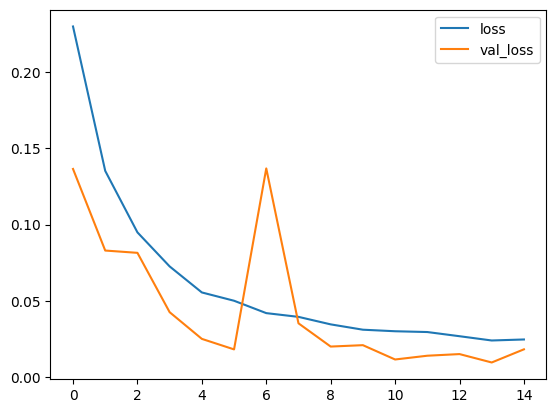

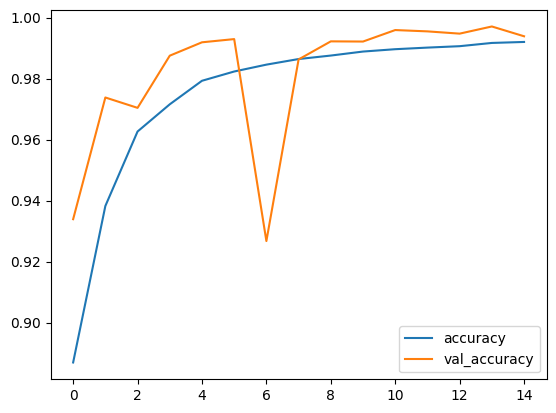

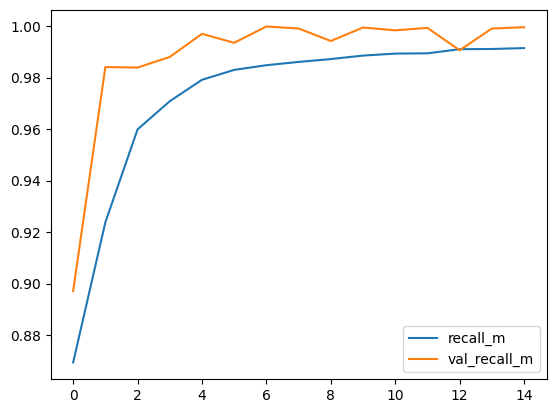

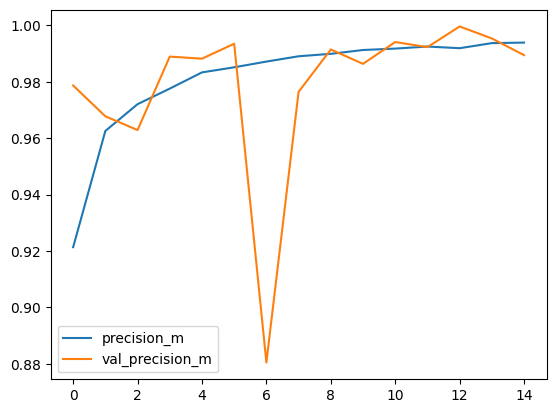

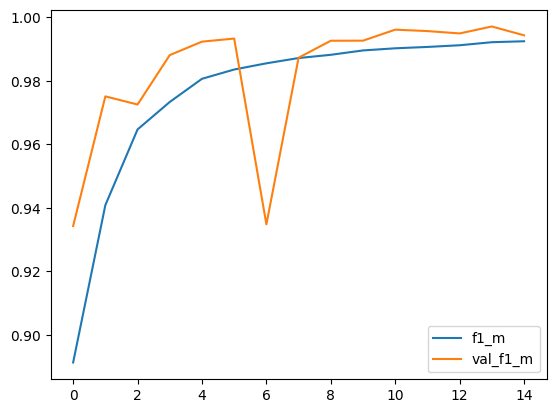

In [72]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss',]].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy',]].plot()
history_frame.loc[:, ['recall_m', 'val_recall_m',]].plot()
history_frame.loc[:, ['precision_m', 'val_precision_m',]].plot()
history_frame.loc[:, ['f1_m', 'val_f1_m',]].plot()

This is a backup to recover our work, to avoid losing hours of computation:

In [73]:
model.save('/kaggle/working/model3.h5')   #backup to avoid losing my trained model !!!
# model = load_model('/kaggle/working/model.h5')   #if I ever need to recover my model

with open('history3.txt', 'w') as f:
    np.savetxt(f, np.column_stack((history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])), header='loss accuracy val_loss val_accuracy')
# history = np.loadtxt('history.txt', delimiter=' ')   #if I ever need to recover the history

# Info from Kaggle:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Prediction
Now let's measure our model's 'real-world' performance.
Again, I need to correct the paths to the images.

In [74]:
test['actual_img_path'] = test['img_path'].apply(lambda x: x.split("/")[2])
test.head()

,img_path,printer_id,print_id,actual_img_path
0,101/1678578332/1678578538.704966.jpg,101,1678578332,1678578538.704966.jpg
1,101/1678578332/1678578539.108019.jpg,101,1678578332,1678578539.108019.jpg
2,101/1678578332/1678578539.512872.jpg,101,1678578332,1678578539.512872.jpg
3,101/1678578332/1678578539.916711.jpg,101,1678578332,1678578539.916711.jpg
4,101/1678578332/1678578540.329089.jpg,101,1678578332,1678578540.329089.jpg


It might seem peculiar, but I will again use an ImageDataGenerator for the test set. In this case it is not to generate new data, but rather to predict in **batches** (of 32), just like during the training, and thus have a faster and more efficient prediction.

In [75]:
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_dataframe(
    test,
    directory='/kaggle/input/early-detection-of-3d-printing-issues/test',
    x_col='actual_img_path',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 25279 validated image filenames.


In [76]:
predictions = model.predict_generator(
    test_generator,
    steps=test_generator.n // 32 + 1,
    verbose=1
)
predictions = predictions.astype(np.int64)   #convert to int
submission = pd.DataFrame({'img_path': test['img_path'], 'has_under_extrusion': predictions.flatten()})
submission.to_csv('submission_3.csv', index=False)

/tmp/ipykernel_31/3415647803.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(


790/790 [==============================] - 315s 398ms/step


## Results !
These are our results reported by the Kaggle challenge page:

| Submission       | Private Score | Public Score |
| ---------------- | ------------- | ------------ |
| *submission_1*   | 0.83022       | 0.4388     |
| *submission_2*   | 0.73655       | 0.44432    |
| *submission_3*   | 0.86629       | 0.52654    |

**submission_1** was our very first result.
For **submission_2**, we increased the number of *convolution layers* and *dense layers*, and also significantly increased the *dropout* amount to attempt to counter the overfitting.
For **submission_3**, we used the same model as submission_2, but reverted to a random train-test split (instead of retaining a printer).

There is quite a big discrepancy between the private and public score here. There are multiple possible reasons for this. The most likely explanation is that this low public score is the consequence of **overfitting**.

If we indeed have overfitted, it would not be surprising, since we only have data for 7 printers (which is way too small a sample considering how different the images look from one printer to another).

Some of the ways we could have addressed this overfitting are :
- Employ cross-validation
- Explore additional data augmentation
- Use even more aggressive dropout
- Fine-tune hyperparameters (batch size, learning rate, optimizer settings...)

It is also worth noting we have uncovered a problem in the provided data from the start: the target is constant throughout a print_id. This means that every image in a print which ended up having an under extrusion problem is labeled as having under extrusion. You can quickly identify a problem here : even if there is no under extrusion visible in an image, it might be labeled otherwise because the under extrusion might happen later in that same print !
One way to tackle this would have been to 'group' all images of a same print as a single input of the model, but this would not have been a viable option due to how tiny that would have made the sample.

For time-related reasons, we have not attempted to train our model more than 3 times, since this can easily last a couple of hours. 